In [62]:
# Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from main import create_dataframe


In [63]:
# Import data
data_raw = pd.read_csv('tested_molecules.csv')


In [69]:
# Make a dataframe with all the molecular descriptors

df_descriptors= create_dataframe(data_raw)

inhibitors1= df_descriptors[(df_descriptors['PKM2_inhibition'] == 1)]
inhibitors2= df_descriptors[(df_descriptors['ERK2_inhibition'] == 1)]
noninhibitors= df_descriptors[(df_descriptors['PKM2_inhibition'] == 0) & (df_descriptors['ERK2_inhibition'] == 0)]
df_descriptors= df_descriptors.drop(columns = ['SMILES','PKM2_inhibition','ERK2_inhibition'])
pd.set_option('display.max_columns', None)



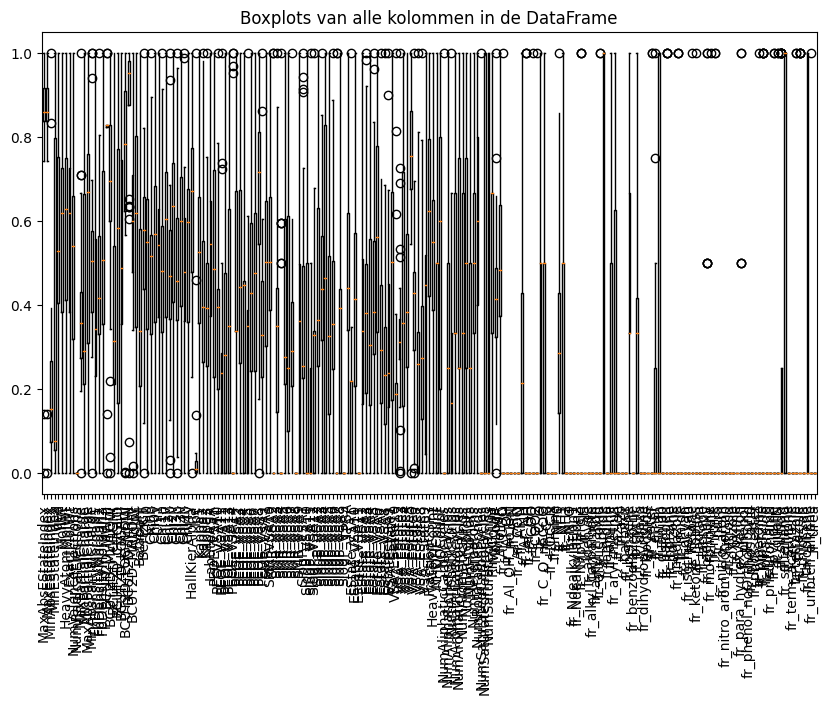

In [70]:
inhibitors1= inhibitors1.drop(columns = ['SMILES','PKM2_inhibition','ERK2_inhibition'])
scaler= MinMaxScaler()
inhibitors1_scaled= scaler.fit_transform(inhibitors1)
inhibitors1_scaled= pd.DataFrame(inhibitors1_scaled)
# Boxplots van alle kolommen
plt.figure(figsize=(10, 6))
plt.boxplot([inhibitors1_scaled[col] for col in inhibitors1_scaled.columns], labels=inhibitors1.columns)
plt.xticks(rotation=90)
plt.title('Boxplots van alle kolommen in de DataFrame')
plt.show()

In [72]:
inhibitors2

,SMILES,PKM2_inhibition,ERK2_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
1039,N#C/C(=C1\CCC[NH2+]1)c1ccc2ccccc2n1,0,1,9.344080,9.344080,0.734494,0.734494,0.767866,236.298,222.186,236.118224,88,0,0.133775,-0.316224,0.316224,0.133775,1.222222,2.111111,2.888889,14.909518,10.079888,2.185104,-2.025163,2.201812,-2.784992,5.834354,-0.589756,2.933725,2.135529,656.738204,12.372033,10.057199,10.057199,8.881341,6.209331,6.209331,4.497587,4.497587,3.328452,3.328452,2.396777,2.396777,-2.18,2.970103e+04,10.941768,4.594738,1.873383,105.769376,5.316789,17.339365,0.000000,0.000000,0.000000,0.000000,0.000000,4.983979,5.261892,0.000000,24.265468,12.132734,18.227867,17.755385,5.316789,16.476029,5.261892,4.983979,0.000000,12.841643,6.544756,47.789170,0.0,6.069221,5.316789,0.000000,0.000000,0.000000,11.528735,0.000000,11.331113,18.535571,42.095242,0.000000,16.476029,0.0,53.29,0.000000,5.261892,0.0,0.000000,0.000000,47.253396,0.000000,0.000000,36.398202,16.369988,0.000000,0.000000,0.000000,4.590602,12.616338,3.628918,0.000000,14.275661,2.144340,1.077475,0.000000,0.200000,18,2,3,0,1,1,1,1,2,2,1,3,1,0,1,1,3,1.82668,70.3024,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1040,Nc1ccn([C@H]2CC[C@@H](CO)O2)c(=O)n1,0,1,11.451388,11.451388,0.020187,-0.417972,0.687546,211.221,198.117,211.095691,82,0,0.351119,-0.393676,0.393676,0.351119,1.666667,2.466667,3.066667,16.526503,10.224018,2.259966,-2.136400,2.258894,-2.272486,5.230420,-0.024496,2.656

In [73]:
noninhibitors

,SMILES,PKM2_inhibition,ERK2_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C=C(C)c1nc(N)nc(N)n1,0,0,5.313889,5.313889,0.120833,0.120833,0.592228,151.173,142.101,151.085795,58,0,0.224863,-0.367629,0.367629,0.224863,1.181818,1.636364,2.000000,15.136768,10.324116,1.999502,-1.985357,2.061950,-2.047656,5.553819,1.044248,1.846047,3.186013,272.774159,8.430721,6.203448,6.203448,5.092224,3.022544,3.022544,2.155745,2.155745,1.051723,1.051723,0.600230,0.600230,-1.65,2.436782e+02,7.456952,2.531038,1.635047,64.175352,11.467335,0.000000,5.824404,11.896679,0.000000,0.000000,0.000000,0.000000,14.951936,0.000000,6.578936,12.496842,0.000000,0.000000,0.000000,17.469783,0.0,14.951936,0.000000,6.923737,11.467335,12.403340,0.0,0.000000,11.467335,11.896679,0.000000,0.000000,14.951936,0.000000,0.000000,12.748142,6.578936,0.000000,5.573105,0.0,90.71,0.000000,0.000000,0.0,11.896679,11.397509,0.000000,0.000000,6.923737,0.000000,21.530871,11.467335,0.000000,0.000000,11.227963,0.000000,11.341481,0.681481,0.000000,0.000000,5.415741,0.000000,0.166667,11,4,5,0,0,0,0,1,1,5,2,5,1,0,0,0,1,0.06910,43.3598,0,0,0,2,0,3,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,11.238954,11.238954,0.225308,-0.366756,0.785414,250.681,239.593,250.039672,88,0,0.335962,-0.487877,0.487877,0.335962,1.470588,2.235294,2.941176,35.495704,10.129819,2.036408,-2.058730,2.220550,-1.991714,6.289504,0.359025,2.250829,2.428298,628.087447,12.413849,9.32

In [ ]:
# Check if there are columns without variation
non_variating_columns = df_descriptors.columns[df_descriptors.nunique()==1].tolist()
print(non_variating_columns) # Use this also to later delete these when testing the test set
# These columns do not add anything, so these get deleted
df_descriptors.drop(columns = non_variating_columns, inplace = True)


['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'fr_HOCCN', 'fr_SH', 'fr_aldehyde', 'fr_azide', 'fr_azo', 'fr_benzodiazepine', 'fr_diazo', 'fr_epoxide', 'fr_hdrzine', 'fr_hdrzone', 'fr_isocyan', 'fr_isothiocyan', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_term_acetylene', 'fr_thiocyan']


In [74]:
# Apply Min-Max scaling
scaler= MinMaxScaler()
df_descriptors_scaled= scaler.fit_transform(df_descriptors)

# Apply PCA
pca = PCA()
components = pca.fit_transform(df_descriptors_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to capture at least 90% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1

# Print the result
print(f'Number of principal components needed to capture at least 70% variance: {num_components}')

Number of principal components needed to capture at least 70% variance: 59


In [75]:
# Perform PCA with 16 components
number_of_components= 59
pca = PCA(n_components=number_of_components)
pca_scores = pca.fit_transform(df_descriptors_scaled)

# Create a DataFrame with PCA scores
pca_df = pd.DataFrame(data=pca_scores, columns=['PC'+ str(number+1) for number in range(number_of_components)])

pca_loadings_df= pd.DataFrame(data= pca.components_.T , columns=['PC'+ str(number +1)+ '_loading' for number in range(number_of_components)])


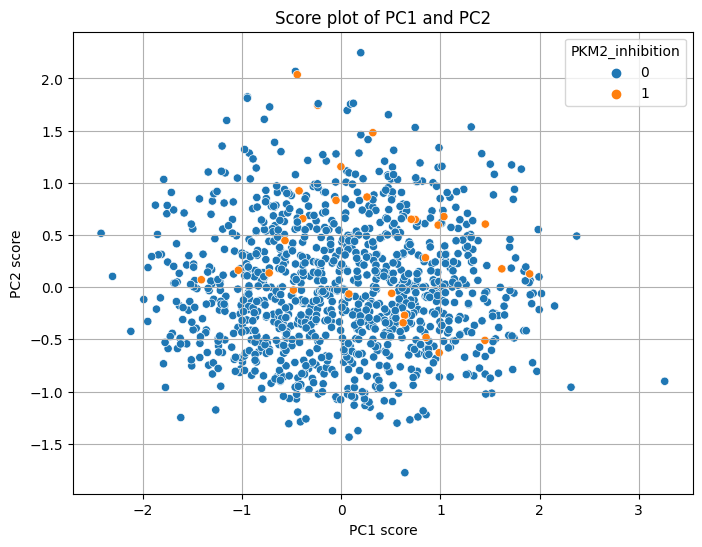

In [76]:
# Plot the PCA scores
pca_df['PKM2_inhibition']= data_raw['PKM2_inhibition']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue= 'PKM2_inhibition')
plt.xlabel('PC1 score')
plt.ylabel('PC2 score')
plt.title('Score plot of PC1 and PC2')
plt.grid(True)
plt.show()

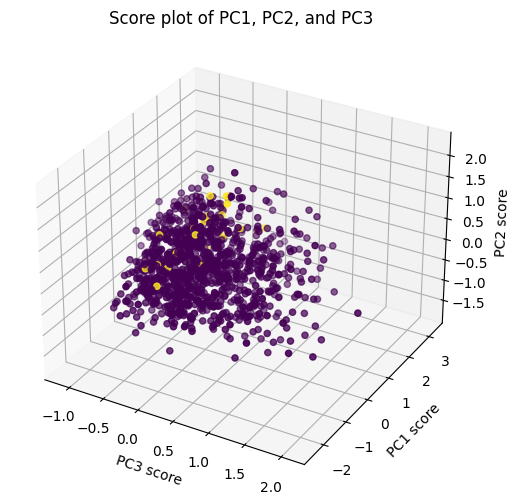

In [ ]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df['PC3'], pca_df['PC1'], pca_df['PC2'], c=pca_df['PKM2_inhibition'], cmap='viridis')

ax.set_xlabel('PC3 score')
ax.set_ylabel('PC1 score')
ax.set_zlabel('PC2 score')
ax.set_title('Score plot of PC1, PC2, and PC3')
ax.grid(True)

plt.show()

In [ ]:
from sklearn import svm
X= pca_df
y= data_raw['PKM2_inhibition']
clf = svm.SVC()
clf.fit(X, y)